In [25]:
import functions as f #self-defined functions in functions.py
import kwant
import tinyarray as tiny
import numpy as np 
import scipy.sparse.linalg as sla
from types import SimpleNamespace
# import holoviews as hv
# from holoviews import opts
# from matplotlib import pyplot as plt
# hv.extension('matplotlib', logo=False) #BOKEH DOESNT SUPPORT LATEX IN LABELS
# hv.extension('bokeh', logo=False)
import datetime, time
from matplotlib import pyplot as plt
pauli=f.pauli
# spin_vector = [pauli.s0sx,pauli.s0sy,pauli.s0sz]
dims = dict(kx = 'k_x',ky = 'k_y', mu = 'µ', delta = 'Δ', t = 't', E='ε',mu_t = 'µ/t', azi_winding='q', radi_winding= 'p', \
           radius = 'r', R0 = 'R_0', j='j')

In [26]:
def magn_texture(position, radius=10, azi_winding=1, radi_winding=1):
    x,y = position
    theta = np.arctan2(x,y)
    q = azi_winding
    p = radi_winding
    R = radius
    r = np.sqrt(x**2 + y**2)
    B = [np.sin(np.pi*p*(r/R))*np.cos(q*theta), np.sin(np.pi*p*(r/R))*np.sin(q*theta), np.cos(np.pi*p*(r/R))]
    return B

def onsite(site, radius, t, mu, j, azi_winding, radi_winding, delta): #define a function to determine the onsite energy term of the Hamiltonian
    position = site.pos #site is a class! Apart from real space position contains the type of atom (to which family it belongs, how many orbitals etc)
    B = magn_texture(position, radius, azi_winding, radi_winding) #calculate direction of magnetic field at position (x,y)
    skyrmion_interaction = j*(B[0]*pauli.s0sx + B[1]*pauli.s0sy + B[2]*pauli.s0sz)
    return 4*t*pauli.szs0 - mu*pauli.szs0 + delta*pauli.sxs0 + skyrmion_interaction
    
def hopping(position1,position2,t): #define the hopping terms in your system
    return -t*pauli.szs0

def build_disk(radius=10, plot=False):
    sys = kwant.Builder() #initialize your system
    sqlat = kwant.lattice.square(norbs=2)

    #define a Boolean function to shape your system
    def disk(position): 
        x,y = position
        return x**2 + y**2 < radius**2

    sys[sqlat.shape(disk,(0,0))]= onsite
    sys[sqlat.neighbors()]= hopping

    if plot:
        system_plot = kwant.plot(sys)
        
    return sys.finalized()

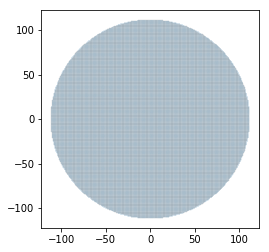

Lambda = 16.0
Radius = 112
Sites = 39377
k = 262


In [27]:
params = dict(t=1, mu=0, j=0.2, delta=0.1, azi_winding=2, radi_winding=7)#delta cannot be zero
radius = 16*params['radi_winding'] #-> constant lambda
skyrmion = build_disk(radius, plot=1)
params['radius']=radius
ham = skyrmion.hamiltonian_submatrix(params=params, sparse=True)
k = len(skyrmion.sites)//150 #to roughly maintain the ratio of number of states we keep vs total number of states
print('Lambda = {:.1f}\nRadius = {:d}\nSites = {:d}\nk = {:d}'.format(params['radius']/params['radi_winding'],params['radius'],len(skyrmion.sites),k))


Let's check that the we defined the skyrmion right:

In [23]:
b_z_e = np.real(ham.diagonal()[::4])-(4*params['t']-params['mu']) #Since our function now only contains the magnetic term, we take out the Bz component to check
b_z_h = np.real(ham.diagonal()[2::4])+(4*params['t']-params['mu']) #Since our function now only contains the magnetic term, we take out the Bz component to check

In [24]:
np.sum(np.abs(b_z_e - b_z_h))

8.22808488010196e-12

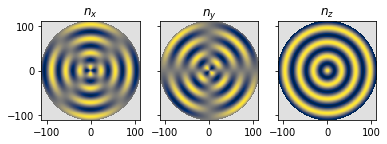

In [11]:
b_z = np.real(ham.diagonal()[::4])-(4*params['t']-params['mu']) #Since our function now only contains the magnetic term, we take out the Bz component to check
b_x = np.real(ham.diagonal(k=1)[::4])
b_y = np.imag(ham.diagonal(k=1)[::4])
opts = dict(cmap='cividis', oversampling=1, num_lead_cells=2, vmin=-params['j'], vmax=params['j'])
fig, ax = plt.subplots(1,3, sharey=True)
ax[0].set_title('$n_x$')
kwant.plotter.map(skyrmion, b_x, **opts, ax=ax[0])
ax[1].set_title('$n_y$')
kwant.plotter.map(skyrmion, b_y, **opts, ax=ax[1])
ax[2].set_title('$n_z$')
kwant.plotter.map(skyrmion, b_z, **opts, ax=ax[2])
plt.show()
plt.close()
# fig.savefig('fig/check_kwant_skyrmion_q={:d}.png'.format(params['azi_winding']), dpi=250, bbox='tight')

Define a function that solves the sparse system and outputs the spectrum

In [28]:
def solve_sparse(sys, params, k=32, sigma=0, timing=False, show_plot=True, save_plot_to = None):
    '''
    params:
    
    save_to : needs to be a path 
    returns : First k sorted eigenpairs with eigenvalues around sigma. 
    '''
    ham = sys.hamiltonian_submatrix(params=params, sparse=True)   
    
    if timing:
        import time
        t1 = time.time()
        eigen = sla.eigsh(ham, k=k, sigma=sigma)
        t2 = time.time()
        print('Hamiltonian size = {0:d}x{0:d} \nSolving for {1:d} solutions around 0 took {2:.3f}s'.format(ham.shape[0],k,t2-t1))

    else:
        eigen = sla.eigsh(ham, k=k, sigma=sigma)
        
    p = eigen[0].argsort() #find the permutation that sorts the eigenvalues
    eVec= eigen[1][:,p] #sort the eigenvectors with that same permutation
    eVal = eigen[0][p]
    
    if show_plot or not save_plot_to == None:
        from matplotlib import pyplot as plt
        plt.plot(eVal/params['delta'],'.')
        plt.xlim(0,len(eVal))
        plt.suptitle('Spectrum (k={})'.format(k))
        plt.ylabel('$\epsilon/\Delta$', fontsize=14)

        pars = params.copy()
        param_text= '\n'

        for key in pars:
            param_text = param_text + ' {} = {} \n'.format(dims[key], pars[key])    
        # place text boxes
        plt.text(1.05, 0.5, param_text, fontsize=14, horizontalalignment='left',transform = plt.gca().transAxes,\
             verticalalignment='center', bbox=dict(facecolor='grey', alpha=0.1))

        if not save_plot_to==None:
            if not isinstance(save_plot_to, str):
                raise Exception('Path has to be a string')
            plt.savefig(save_plot_to + '\spectrum.png', dpi=250, bbox_inches='tight')        
        
        plt.show()
        plt.close()
        
    return (eVal, eVec)

Define a path where to save stuff and make a folder if it doesn't exist yet

In [30]:
import os, sys
today = datetime.date.today() 
todaystr = today.isoformat()
data_path = r'C:\Users\Arfor\Documents\Internship 1 - Skyrmion Quantum Transport\Data'
new_path = data_path + r'\{}_r={:d}_p={}_q={}'.format(todaystr, radius, params['radi_winding'], params['azi_winding'])
if not os.path.exists(new_path):
    os.mkdir(new_path)

C:\ProgramData\Anaconda3\envs\lps\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Hamiltonian size = 80276x80276 
Solving for 300 solutions around 0 took 246.203s


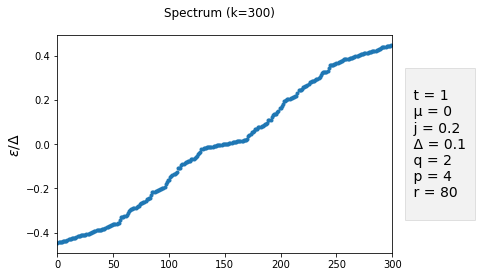

In [75]:
eVal, eVec = solve_sparse(skyrmion, params, k=289, save_plot_to=new_path, timing=True)

In [76]:
data = params.copy()
data['eVec']=eVec
data['eVal'] = eVal

In [77]:
#Save everything
import pickle
pickle_out = open(new_path+"\data.pickle","ab")
pickle.dump(data, pickle_out)
pickle_out.close()

In [78]:
#check if saving worked
pickle_in = open(new_path + "\data.pickle","rb")
example_dict = pickle.load(pickle_in)
example_dict.keys()

dict_keys(['t', 'mu', 'j', 'delta', 'azi_winding', 'radi_winding', 'radius', 'eVec', 'eVal'])

In [20]:
def plot_density(sys, params, eigen, n):
    #sys = Kwant system, eigen=(eVal, eVec), n= number of wavefunction to plot
    eVal, eVec = eigen
    prob_dens = np.abs(eVec)**2
    
    vmax=np.max(prob_dens[:,n])

    fig, axes = plt.subplots(2,2, sharey=True, sharex=True, figsize=(6,6))

    plt.suptitle('Wavefunction to $\epsilon$={:.3E}'.format(eVal[n]), y=1,fontsize=16)
    
    axes[0,0].set_title('$c^{\\dagger}_{\\uparrow}$')

    kwant.plotter.density(sys, prob_dens[0::4, n], vmin=0, vmax=vmax, cmap='magma', ax = axes[0,0], background='#000000')
    axes[0,0].text(0.025, 1.05,'|ψ|={:.2f}'.format(np.sum(prob_dens[0::4, n])), \
         transform = axes[0,0].transAxes, bbox=dict(facecolor='white', alpha=0.5))

    axes[0,1].set_title('$c^{\\dagger}_{\\downarrow}$')
    kwant.plotter.density(sys, prob_dens[1::4, n], vmin=0, vmax=vmax, ax=axes[0,1], cmap='inferno',background='#000000')
    axes[0,1].text(0.025, 1.05,'|ψ|={:.2f}'.format(np.sum(prob_dens[1::4, n])), \
         transform = axes[0,1].transAxes, bbox=dict(facecolor='white', alpha=0.5))

    axes[1,0].set_title('$c^{}_{\\uparrow}$')
    kwant.plotter.density(sys, prob_dens[3::4, n], vmin=0, vmax=vmax, ax=axes[1,0], cmap='inferno',background='#000000')
    axes[1,0].text(0.025, 1.05,'|ψ|={:.2f}'.format(np.sum(prob_dens[3::4, n])), \
         transform = axes[1,0].transAxes, bbox=dict(facecolor='white', alpha=0.5))

    axes[1,1].set_title('$c^{}_{\\downarrow}$')
    kwant.plotter.density(sys, prob_dens[2::4, n], vmin=0, vmax=vmax, ax=axes[1,1], cmap='inferno',background='#000000')
    axes[1,1].text(0.025, 1.05,'|ψ|={:.2f}'.format(np.sum(prob_dens[2::4, n])), \
         transform = axes[1,1].transAxes, bbox=dict(facecolor='white', alpha=0.5))

    pars = params.copy()
    param_text= '\n'

    for key in pars:
        param_text = param_text + ' {} = {} \n'.format(dims[key], pars[key])    
    # place text boxes
    fig.text(0.95, 0.5, param_text, fontsize=14, horizontalalignment='left',\
         verticalalignment='center', bbox=dict(facecolor='grey', alpha=0.1))
    
    return fig

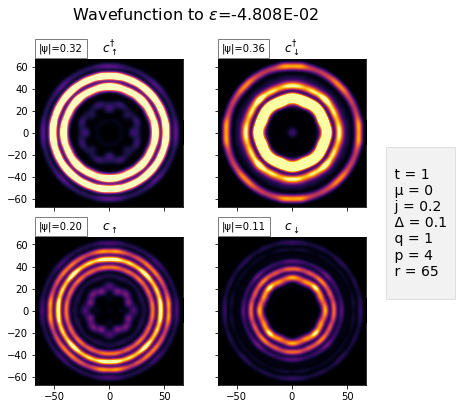

In [30]:
wf = plot_density(skyrmion, params, (eVal,eVec), n=7)

In [28]:
for n in range(24):
    wf = plot_density(skyrmion, params, (eVal,eVec), n=n)
    wf.savefig(new_path+'\wf{}__e={:.2E}.png'.format(n,eVal[n]), bbox_inches='tight', dpi=50, metadata=params) #plot as png to check more easy than svg
    plt.close(wf)

In [182]:
np.shape(example_dict['eVal'])

(264,)